<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 476, '日付': '2021-06-29T08:00:00.000Z'},
 {'小計': 714, '日付': '2021-06-30T08:00:00.000Z'},
 {'小計': 673, '日付': '2021-07-01T08:00:00.000Z'},
 {'小計': 660, '日付': '2021-07-02T08:00:00.000Z'},
 {'小計': 716, '日付': '2021-07-03T08:00:00.000Z'},
 {'小計': 518, '日付': '2021-07-04T08:00:00.000Z'},
 {'小計': 342, '日付': '2021-07-05T08:00:00.000Z'},
 {'小計': 593, '日付': '2021-07-06T08:00:00.000Z'},
 {'小計': 920, '日付': '2021-07-07T08:00:00.000Z'},
 {'小計': 896, '日付': '2021-07-08T08:00:00.000Z'},
 {'小計': 822, '日付': '2021-07-09T08:00:00.000Z'},
 {'小計': 950, '日付': '2021-07-10T08:00:00.000Z'},
 {'小計': 614, '日付': '2021-07-11T08:00:00.000Z'},
 {'小計': 502, '日付': '2021-07-12T08:00:00.000Z'},
 {'小計': 830, '日付': '2021-07-13T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-07-09 17:00:00+09:00,504,0,822,2021-07-09 17:00:00+09:00
2021-07-10 17:00:00+09:00,502,0,950,2021-07-10 17:00:00+09:00
2021-07-11 17:00:00+09:00,403,0,614,2021-07-11 17:00:00+09:00
2021-07-12 17:00:00+09:00,509,0,502,2021-07-12 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-07-09 17:00:00+09:00,504,0,822,2021-07-09 17:00:00+09:00,436.142857,3053.0,0.0,0.0,686.714286,4807.0
2021-07-10 17:00:00+09:00,502,0,950,2021-07-10 17:00:00+09:00,446.428571,3125.0,0.0,0.0,720.142857,5041.0
2021-07-11 17:00:00+09:00,403,0,614,2021-07-11 17:00:00+09:00,453.285714,3173.0,0.0,0.0,733.857143,5137.0
2021-07-12 17:00:00+09:00,509,0,502,2021-07-12 17:00:00+09:00,468.857143,3282.0,0.0,0.0,756.714286,5297.0
2021-07-13 17:00:00+09:00,0,0,830,2021-07-13 17:00:00+09:00,406.571429,2846.0,0.0,0.0,790.571429,5534.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-06-29 17:00:00+09:00,352,0,476,2021-06-29 17:00:00+09:00,360.428571,2523.0,0.0,0.0,494.857143,3464.0,'21w26,Tue
2021-06-30 17:00:00+09:00,412,0,714,2021-06-30 17:00:00+09:00,365.714286,2560.0,0.0,0.0,508.428571,3559.0,'21w26,Wed
2021-07-01 17:00:00+09:00,444,0,673,2021-07-01 17:00:00+09:00,380.000000,2660.0,0.0,0.0,523.142857,3662.0,'21w26,Thu
2021-07-02 17:00:00+09:00,451,0,660,2021-07-02 17:00:00+09:00,393.571429,2755.0,0.0,0.0,537.142857,3760.0,'21w26,Fri
2021-07-03 17:00:00+09:00,430,0,716,2021-07-03 17:00:00+09:00,405.714286,2840.0,0.0,0.0,563.142857,3942.0,'21w26,Sat
2021-07-04 17:00:00+09:00,355,0,518,2021-07-04 17:00:00+09:00,405.000000,2835.0,0.0,0.0,582.000000,4074.0,'21w26,Sun
2021-07-05 17:00:00+09:00,400,0,342,2021-07-05 17:00:00+09:00,406.285714,2844.0,0.0,0.0,585.571429,4099.0,'21w27,Mon
2021-07-06 17:00:00+09:00,436,0,593,2021-07-06 17:00:00+09:00,418.285714,2928.0,0.0,0.0,602.285714,4216.0,'21w27,Tue
2021-07-07 17:00:00+09:00,494,0,920,2021-07-07 17:00:00+09:00,430.000000,3010.0,0.0,0.0,631.714286,4422.0,'21w27,Wed
2021-07-08 17:00:00+09:00,434,0,896,2021-07-08 17:00:00+09:00,428.571429,3000.0,0.0,0.0,663.571429,4645.0,'21w27,Thu


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-06-27 17:00:00+09:00,477.428571,3342
2021-07-04 17:00:00+09:00,582.000000,4074
2021-07-11 17:00:00+09:00,733.857143,5137
2021-07-13 17:00:00+09:00,666.000000,1332
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-06-29 17:00:00+09:00,352,0,476,2021-06-29 17:00:00+09:00,360.428571,2523.0,0.0,0.0,494.857143,3464.0,'21w26,Tue,NaN,NaN
2021-06-30 17:00:00+09:00,412,0,714,2021-06-30 17:00:00+09:00,365.714286,2560.0,0.0,0.0,508.428571,3559.0,'21w26,Wed,NaN,NaN
2021-07-01 17:00:00+09:00,444,0,673,2021-07-01 17:00:00+09:00,380.000000,2660.0,0.0,0.0,523.142857,3662.0,'21w26,Thu,NaN,NaN
2021-07-02 17:00:00+09:00,451,0,660,2021-07-02 17:00:00+09:00,393.571429,2755.0,0.0,0.0,537.142857,3760.0,'21w26,Fri,NaN,NaN
2021-07-03 17:00:00+09:00,430,0,716,2021-07-03 17:00:00+09:00,405.714286,2840.0,0.0,0.0,563.142857,3942.0,'21w26,Sat,NaN,NaN
2021-07-04 17:00:00+09:00,355,0,518,2021-07-04 17:00:00+09:00,405.000000,2835.0,0.0,0.0,582.000000,4074.0,'21w26,Sun,582.000000,4074.0
2021-07-05 17:00:00+09:00,400,0,342,2021-07-05 17:00:00+09:00,406.285714,2844.0,0.0,0.0,585.571429,4099.0,'21w27,Mon,NaN,NaN
2021-07-06 17:00:00+09:00,436,0,593,2021-07-06 17:00:00+09:00,418.285714,2928.0,0.0,0.0,602.285714,4216.0,'21w27,Tue,NaN,NaN
2021-07-07 17:00:00+09:00,494,0,920,2021-07-07 17:00:00+09:00,430.000000,3010.0,0.0,0.0,631.714286,4422.0,'21w27,Wed,NaN,NaN
2021-07-08 17:00:00+09:00,434,0,896,2021-07-08 17:00:00+09:00,428.571429,3000.0,0.0,0.0,663.571429,4645.0,'21w27,Thu,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

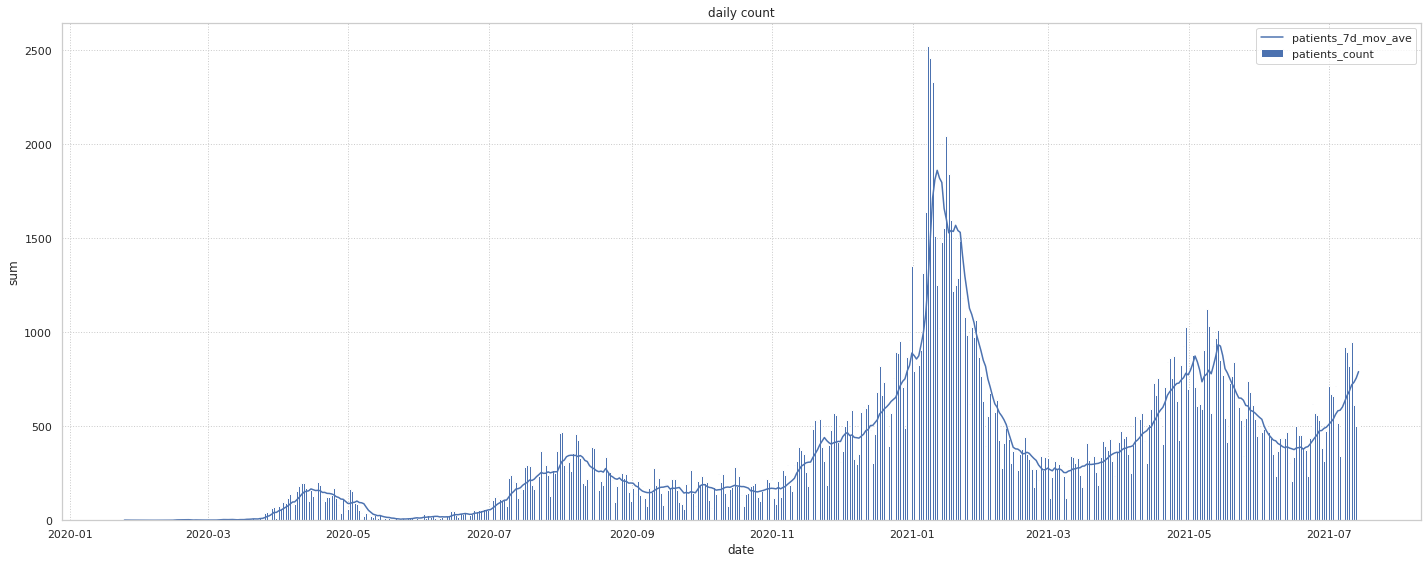

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
522,1.624954e+09,2021,6,29,0,0,0,0,0,1,0,522,0,448,352,360.428571,2523.0,0,0.0,0.0,476,494.857143,3464.0
523,1.625040e+09,2021,6,30,0,0,0,0,0,0,1,523,0,449,412,365.714286,2560.0,0,0.0,0.0,714,508.428571,3559.0
524,1.625126e+09,2021,7,1,0,0,0,0,1,0,0,524,0,450,444,380.000000,2660.0,0,0.0,0.0,673,523.142857,3662.0
525,1.625213e+09,2021,7,2,1,0,0,0,0,0,0,525,0,451,451,393.571429,2755.0,0,0.0,0.0,660,537.142857,3760.0
526,1.625299e+09,2021,7,3,0,0,1,0,0,0,0,526,0,452,430,405.714286,2840.0,0,0.0,0.0,716,563.142857,3942.0
527,1.625386e+09,2021,7,4,0,0,0,1,0,0,0,527,0,453,355,405.000000,2835.0,0,0.0,0.0,518,582.000000,4074.0
528,1.625472e+09,2021,7,5,0,1,0,0,0,0,0,528,0,454,400,406.285714,2844.0,0,0.0,0.0,342,585.571429,4099.0
529,1.625558e+09,2021,7,6,0,0,0,0,0,1,0,529,0,455,436,418.285714,2928.0,0,0.0,0.0,593,602.285714,4216.0
530,1.625645e+09,2021,7,7,0,0,0,0,0,0,1,530,0,456,494,430.000000,3010.0,0,0.0,0.0,920,631.714286,4422.0
531,1.625731e+09,2021,7,8,0,0,0,0,1,0,0,531,0,457,434,428.571429,3000.0,0,0.0,0.0,896,663.571429,4645.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            537 non-null    float64
 1   year                 537 non-null    int64  
 2   month                537 non-null    int64  
 3   day                  537 non-null    int64  
 4   Fri                  537 non-null    uint8  
 5   Mon                  537 non-null    uint8  
 6   Sat                  537 non-null    uint8  
 7   Sun                  537 non-null    uint8  
 8   Thu                  537 non-null    uint8  
 9   Tue                  537 non-null    uint8  
 10  Wed                  537 non-null    uint8  
 11  passed               537 non-null    int64  
 12  emergency            537 non-null    int64  
 13  em_passed            537 non-null    int64  
 14  contacts_count       537 non-null    int64  
 15  contacts_7d_mov_ave  537 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,5.370000e+02,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000
mean,1.603008e+09,2020.361266,5.748603,15.653631,0.143389,0.143389,0.143389,0.143389,0.141527,0.143389,0.141527,268.000000,0.091248,199.167598,648.478585,646.589474,4526.119181,686.255121,686.255121,4803.785847,340.726257,336.650785,2356.525140
std,1.340607e+07,0.480815,3.207111,8.859346,0.350796,0.350796,0.350796,0.350796,0.348889,0.350796,0.348889,155.162818,0.288229,147.590112,427.967140,415.960437,2911.734117,860.282551,775.841791,5430.892539,365.471845,343.560895,2404.956019
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.591430e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,134.000000,0.000000,60.000000,372.000000,373.000000,2611.000000,0.000000,0.000000,0.000000,78.000000,93.142857,652.000000
50%,1.603008e+09,2020.000000,5.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,268.000000,0.000000,194.000000,514.000000,522.857143,3660.000000,0.000000,36.428571,255.000000,239.000000,254.285714,1780.000000
75%,1.614586e+09,2021.000000,8.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,402.000000,0.000000,328.000000,752.000000,737.000000,5159.000000,1327.000000,1320.857143,9246.000000,476.000000,466.428571,3265.000000
max,1.626163e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,536.000000,1.000000,462.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,2520.000000,1861.142857,13028.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.832022,0.094966,-0.019784,-0.005279,0.002639,-0.002639,-1.847350e-18,0.001310,0.005279,-0.001310,1.000000e+00,-0.347499,0.996222,-0.329830,-0.317088,-0.317083,-0.560421,-0.604282,-0.604282,0.616525,0.654283,0.654297
year,8.320224e-01,1.000000,-0.470921,-0.053348,0.002019,0.002019,0.002019,2.018617e-03,-0.005074,0.002019,-0.005074,8.320224e-01,-0.238310,0.848356,-0.313813,-0.295154,-0.295151,-0.600486,-0.665842,-0.665842,0.600468,0.655609,0.655610
month,9.496613e-02,-0.470921,1.000000,-0.026249,-0.012674,0.000593,-0.007699,-4.382022e-03,0.011849,0.005568,0.006846,9.496613e-02,-0.122473,0.059468,0.042208,0.028667,0.028671,0.188801,0.237834,0.237834,-0.099422,-0.139948,-0.139928
day,-1.978400e-02,-0.053348,-0.026249,1.000000,0.007006,0.000402,-0.001999,8.206533e-03,-0.007048,-0.008602,0.002006,-1.978400e-02,0.001441,-0.019219,-0.011177,-0.009244,-0.009248,0.016190,0.003272,0.003272,-0.021283,-0.008666,-0.008680
Fri,-5.278537e-03,0.002019,-0.012674,0.007006,1.000000,-0.167391,-0.167391,-1.673913e-01,-0.166120,-0.167391,-0.166120,-5.278537e-03,-0.000481,-0.004429,-0.015520,-0.003092,-0.003091,0.032520,-0.001344,-0.001344,0.047732,-0.003040,-0.003048
Mon,2.639268e-03,0.002019,0.000593,0.000402,-0.167391,1.000000,-0.167391,-1.673913e-01,-0.166120,-0.167391,-0.166120,2.639268e-03,-0.000481,0.002706,0.039545,-0.000509,-0.000508,0.132164,-0.001344,-0.001344,-0.139758,0.001519,0.001521
Sat,-2.639268e-03,0.002019,-0.007699,-0.001999,-0.167391,-0.167391,1.000000,-1.673913e-01,-0.166120,-0.167391,-0.166120,-2.639268e-03,-0.000481,-0.002051,0.045050,-0.002175,-0.002174,-0.155170,-0.001344,-0.001344,0.063172,-0.000942,-0.000947
Sun,-1.847350e-18,0.002019,-0.004382,0.008207,-0.167391,-0.167391,-0.167391,1.000000e+00,-0.166120,-0.167391,-0.166120,-1.948377e-18,-0.000481,0.000328,-0.024380,-0.001439,-0.001438,-0.143059,-0.001344,-0.001344,-0.042331,0.000411,0.000410
Thu,1.309614e-03,-0.005074,0.011849,-0.007048,-0.166120,-0.166120,-0.166120,-1.661203e-01,1.000000,-0.166120,-0.164859,1.309614e-03,0.001209,0.000372,-0.003891,0.004278,0.004279,0.042173,0.003379,0.003379,0.082329,0.000342,0.000347
Tue,5.278537e-03,0.002019,0.005568,-0.008602,-0.167391,-0.167391,-0.167391,-1.673913e-01,-0.166120,1.000000,-0.166120,5.278537e-03,-0.000481,0.005084,-0.030370,-0.000509,-0.000508,0.052000,-0.001344,-0.001344,-0.031504,0.003353,0.003356


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532,1.625818e+09,1,0,0,0,0,0,0,532,0,458,504,0,822,686.714286,4807.0
533,1.625904e+09,0,0,1,0,0,0,0,533,0,459,502,0,950,720.142857,5041.0
534,1.625990e+09,0,0,0,1,0,0,0,534,0,460,403,0,614,733.857143,5137.0
535,1.626077e+09,0,1,0,0,0,0,0,535,0,461,509,0,502,756.714286,5297.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
532,1.625818e+09,532,0,822,686.714286,4807.0
533,1.625904e+09,533,0,950,720.142857,5041.0
534,1.625990e+09,534,0,614,733.857143,5137.0
535,1.626077e+09,535,0,502,756.714286,5297.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

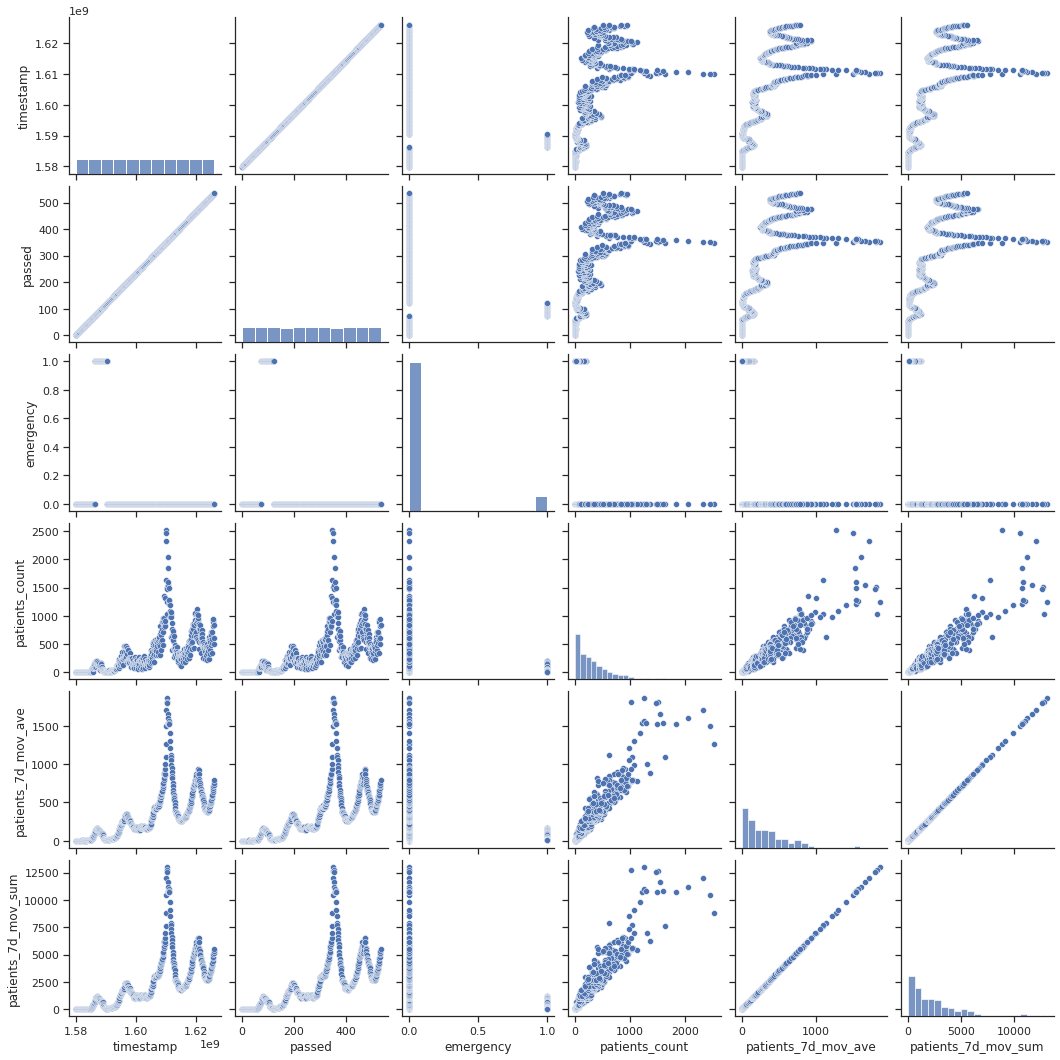

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.10
